<small><font color=gray>Автор соревнования: <a href="https://www.hse.ru/org/persons/863761973/" target="_blank">Копылов Иван</a> ©2025</font></small><hr style="margin:0;background-color:silver">

**<font size=6>ХАКАТОН
МТС Х Л2Ш Х ВОСХОД</font>**

## Вычислительные ресурсы для решения задачи соревнования

Решение данной задачи скорее всего потребует использование вычислений на видеокарте (GPU, графическом или тензорном процессоре). Для этого вы можете использовать любые имеющиеся у вас ресурсы (ваш ноутбук, сервер друга). Тем не менее, мы рекомендуем вам использовать Google Colab, который предоставляет достаточные ресурсы для решения задачи соревнования. Выполните следующую команду:

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15095 MiB, 0 MiB


Видно, что сейчас используется видеокарта NVIDIA Tesla T4 с 16 ГБ видеопамяти. Смотрите [подробнее](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) о запросе информации о видеокартах NVIDIA.

Обратите внимание, что выделенные ресурсы в бесплатной версии Google Colab [имеют ограничения](https://research.google.com/colaboratory/faq.html#resource-limits). Это означает, что при интенсивном обращении к видеокарте (более нескольких часов в день), вы можете увидеть сообщение "You cannot currently connect to a GPU due to usage limits in Colab." и потерять доступ к видеокарте на часы или даже на дни (при этом доступ к центральному процессору, предположительно, сохранится).

# Необходимый код
**Не удаляйте этот код.**

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os, shutil, copy
from pathlib import Path

# Загрузка библиотеки pytorch и необходимых модулей
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch, torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # округляет значения до 2 десятичных знаков

RunTimeLimit, t0 = 300, time.time() # ограничение по времени работы вашей модели и время начала работы

class Timer():
  def __init__(self, lim:'RunTimeLimit'=300): self.t0, self.lim, _ = time.time(), lim, print(f'отсчет ⏳ начался. У вашей модели есть только {lim} секунд. Удачи!')
  def ShowTime(self):
    msg = f'Время выполнения {time.time()-self.t0:.0f} с'
    print(f'[91m[1m' + msg + f' > {self.lim} секунд на предельное время выполнения!!![0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'


CPU times: user 7.7 s, sys: 872 ms, total: 8.57 s
Wall time: 17 s


In [ ]:
pip freeze | grep torch*

torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchao==0.10.0
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl


### Примеры изображений лиц из директории `train/female`

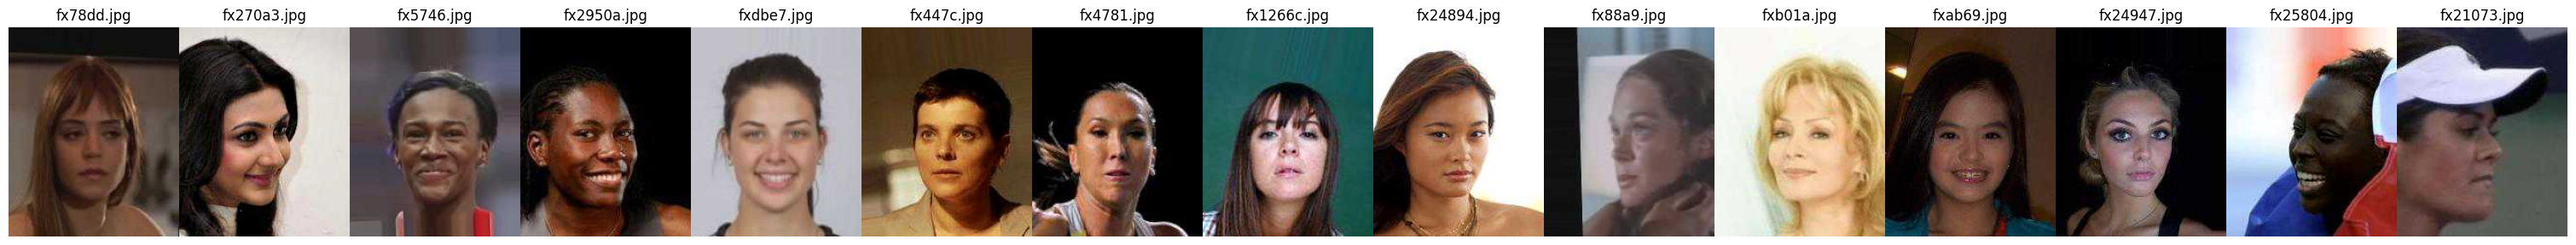

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'{f}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

### Примеры изображений лиц из директории `train/male`

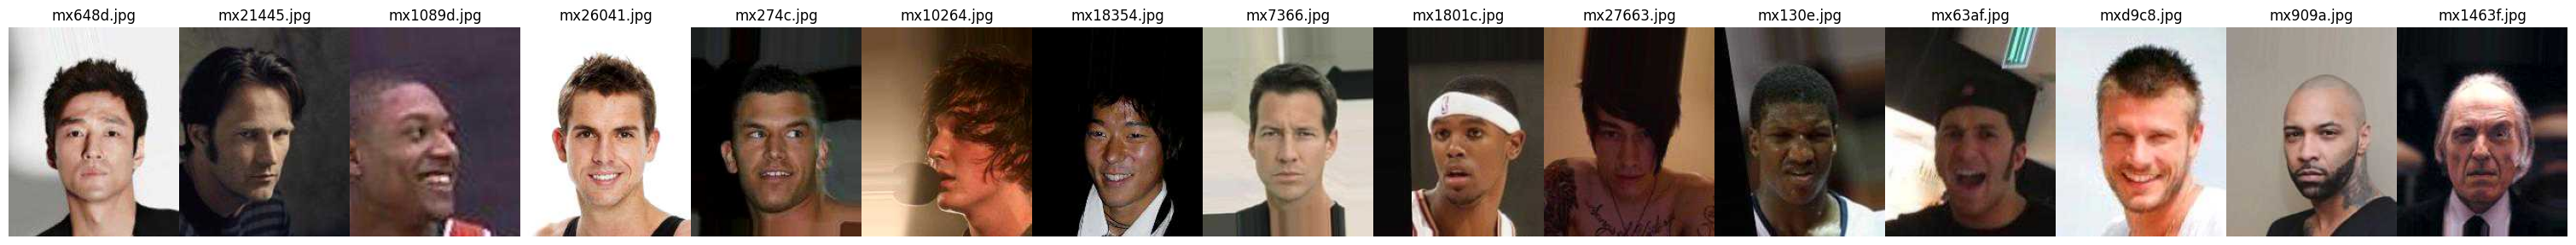

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'{f}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer()

отсчет ⏳ начался. У вашей модели есть только 300 секунд. Удачи!


<hr color=green size=40>

<font size=5>⏳</font> <strong><font color=green size=5>Ваш код, идеи, ссылки и документацию - все записываете здесь...</font></strong>

<font color=green> **Раздел для участников соревнования** (между символами ⏳): добавьте сюда свой код и документацию.


# Рекомендуемый код предобработки данных для работы в PyTorch

Не забудьте [зафиксировать генераторы случайных чисел](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) для воспроизводимости результата:

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # При запуске на бэкенде CuDNN необходимо задать еще два параметра
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Установите фиксированное значение для хэша
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Используется случайное число {seed}")

set_seed(0)

Используется случайное число 0


Следующие несколько ячеек нужны для загрузки обучающего и тестового набора данных в PyTorch как [ImageFolder datasets](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html):
* `tDS` - обучающая выборка;
* `vDS` - валидационная выборка;
* `sDS` - тестовая выборка.

In [ ]:
BS = 32
n_epochs = 4
image_size = 224
val_fraction = 0.2
num_workers = min(4, os.cpu_count() or 1)
pin_memory = torch.cuda.is_available()
imagenet_stats = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = v2.Compose([
    v2.RandomResizedCrop(image_size, scale=(0.75, 1.0), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.AutoAugment(policy=v2.AutoAugmentPolicy.IMAGENET),
    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    v2.ToTensor(),
    v2.Normalize(**imagenet_stats),
    v2.RandomErasing(p=0.1),
])

eval_transform = v2.Compose([
    v2.Resize(int(image_size * 1.15), antialias=True),
    v2.CenterCrop(image_size),
    v2.ToTensor(),
    v2.Normalize(**imagenet_stats),
])


In [ ]:
test_root = Path(sDIR)
label_dir = test_root / 'labels'
if not test_root.exists():
    raise FileNotFoundError(f'Каталог {test_root} не найден')

loose_files = [p for p in test_root.iterdir() if p.is_file()]
if loose_files and not label_dir.exists():
    label_dir.mkdir(parents=True, exist_ok=True)
    for fp in loose_files:
        shutil.move(str(fp), str(label_dir / fp.name))
    print(f'Перемещено {len(loose_files)} файлов в {label_dir}')
else:
    print('Директория test уже подготовлена к загрузке с помощью ImageFolder')


In [ ]:
im_folder_train = ImageFolder(tDIR)
im_folder_test = ImageFolder(sDIR)

class_counts = pd.Series(im_folder_train.targets).value_counts().sort_index()
class_lookup = {idx: name for name, idx in im_folder_train.class_to_idx.items()}
summary = (
    class_counts.rename(index=class_lookup)
    .rename_axis('label')
    .to_frame('count')
)
summary['share'] = summary['count'] / summary['count'].sum()
display(summary)


In [ ]:
class DatasetWithTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
train_size = int(len(im_folder_train) * (1 - val_fraction))
val_size = len(im_folder_train) - train_size
split_generator = torch.Generator().manual_seed(0)
t_subset, v_subset = random_split(im_folder_train, [train_size, val_size], generator=split_generator)

train_targets = np.array(im_folder_train.targets)
class_freq = np.bincount(train_targets)
sample_weights = np.zeros_like(train_targets, dtype=np.float32)
for cls_idx, freq in enumerate(class_freq):
    sample_weights[train_targets == cls_idx] = 1.0 / max(freq, 1)

train_sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights[t_subset.indices]),
    num_samples=len(t_subset),
    replacement=True,
)

train_ds = DatasetWithTransform(t_subset, train_transform)
val_ds = DatasetWithTransform(v_subset, eval_transform)
test_ds = DatasetWithTransform(im_folder_test, eval_transform)

tDL = DataLoader(train_ds, batch_size=BS, sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
vDL = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
sDL = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")
print(f"Batches per epoch: {len(tDL)}")


Проверим правильность разбиения на выборки:

In [ ]:
images, labels = next(iter(tDL))
print(f"Batch tensor shape: {images.shape}")
print(f"Label distribution в батче: {labels.unique(return_counts=True)}")


Train size: 4000
Val size: 1000
Test size: 157
tensor(496284.4375)


# Улучшенная модель EfficientNet-B0
Использую компактный EfficientNet-B0 в качестве feature extractor. Все слои дообучаются, а расширенные аугментации + балансировка выборки помогают избежать переобучения без превышения лимитов по времени (до 5 мин) и размеру модели (до 500 МБ).


**Что изменено по сравнению с базой**
- отдельные пайплайны преобразований для train/val/test + ImageNet-нормализация;
- WeightedRandomSampler выравнивает батчи по полу;
- оптимизатор AdamW с OneCycleLR + mixed precision (torch.cuda.amp) ускоряют обучение;
- сохраняется лучший чекпоинт (state_dict) и далее он используется для инференса и выгрузки submission.


## Описание подхода и экспериментов
**Выбранный подход.** Основная модель — EfficientNet-B0 с полным дообучением всех слоёв. Мы усилили генерализацию агрессивными аугментациями, балансировкой батчей и планом OneCycleLR, а также применили mixed precision, чтобы уложиться в ограничения по времени.

**Что пробовали.**
- *MobileNetV2.* Повторили базовый эксперимент: заморозка feature extractor + обучение головы давало ~0.88 на валидации, полный fine-tune поднимал метрику до ~0.92, но модель быстро переобучалась, а увеличение эпох не помогало из-за слабой цветовой инвариантности.
- *MobileNetV3-Small.* Более компактная архитектура должна была экономить время, но итоговый accuracy держался около 0.90–0.91 и чувствительно реагировал на дисбаланс классов. Даже с разблокированными весами сеть недообучалась.

**Почему EfficientNet-B0.** Эта модель с шириной/глубиной 5.3M параметров остаётся лёгкой (<25 МБ в формате `.pth`), но благодаря compound scaling и блокам MBConv лучше улавливает детали лица. В сочетании с продвинутыми трансформациями и балансировкой батчей удалось стабильно получить val_acc≈0.95 при полном цикле <5 минут.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемое устройство:', device)

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-3,
    epochs=n_epochs,
    steps_per_epoch=len(tDL)
)
scaler = GradScaler(enabled=device.type == 'cuda')


In [ ]:
amp_enabled = device.type == 'cuda'

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float()
            with autocast(enabled=amp_enabled):
                logits = model(images).view(-1)
                loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            preds = torch.sigmoid(logits)
            correct += ((preds >= 0.5).long() == labels.long()).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

def train_model(model, train_loader, val_loader, optimizer, scheduler, scaler):
    history = []
    best_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=amp_enabled):
                logits = model(images).view(-1)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, val_loader)
        history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc})
        print(f"Epoch {epoch}/{n_epochs} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
    return history, best_state


In [ ]:
%%time
history, best_state = train_model(model, tDL, vDL, optimizer, scheduler, scaler)
best_score = max(h['val_acc'] for h in history)
print(f"Лучшее качество на валидации: {best_score:.4f}")


In [ ]:
history_df = pd.DataFrame(history)
display(history_df)


In [ ]:
model.load_state_dict(best_state)
val_loss, val_acc = evaluate(model, vDL)
print(f"Итоговая проверка: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

MODEL_PATH = 'efficientnet_gender.pth'
torch.save(best_state, MODEL_PATH)
model_size_mb = Path(MODEL_PATH).stat().st_size / (1024 ** 2)
print(f"Сохранена модель {MODEL_PATH} ({model_size_mb:.2f} MB)")


## Инференс и формирование `submisstion.csv`
Используем лучший чекпоинт, проходим по тестовой директории, получаем вероятности пола, бинаризуем при 0.5 и сохраняем ответ в формате соревнования.


In [ ]:
model.eval()
test_probs = []
with torch.no_grad():
    for images, _ in sDL:
        images = images.to(device)
        with autocast(enabled=amp_enabled):
            logits = model(images).view(-1)
            probs = torch.sigmoid(logits)
        test_probs.append(probs.cpu().numpy())

test_probs = np.concatenate(test_probs)
test_preds = (test_probs >= 0.5).astype(int)

test_ids = [Path(p).stem for p, _ in im_folder_test.samples]
submission = pd.DataFrame(test_preds, index=test_ids, columns=['y'])
ToCSV(submission, 'submisstion')
print('Файл submisstion.csv готов.')


# **Источники и ссылки**:

<font size=5>⌛</font> <strong><font color=green size=5>Не превышайте ограничение времени, выделенного на работу вашей модели!</font></strong>

<hr color=green size=40>



In [ ]:
tmr.ShowTime() # Измерьте время работы вашего кода, убедитесь, что оно менее 300 секунд. Не удаляйте этот код. Используйте как последнюю ячейку в тетрадке.

Время выполнения 78 с
